In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-potential-spammers-on-fiverr/sample_submission.csv
/kaggle/input/predict-potential-spammers-on-fiverr/train.csv
/kaggle/input/predict-potential-spammers-on-fiverr/test.csv


## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
import xgboost as xgb

from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv


## 2. Loading the Dataset

In [3]:
# reading the train and test set data into train and test variable
train = pd.read_csv('/kaggle/input/predict-potential-spammers-on-fiverr/train.csv')
test = pd.read_csv('/kaggle/input/predict-potential-spammers-on-fiverr/test.csv')
train.label.value_counts()

0    446477
1     12321
Name: label, dtype: int64

We can clearly see that this dataset is very much imbalanced

### 2.1. Getting to know data

In [4]:
# now let's check the dimensions of train and test set
print(f"Dimensions of train data : {train.shape}")
print(f"Dimensions of test data : {test.shape}")

Dimensions of train data : (458798, 53)
Dimensions of test data : (24148, 52)


In [5]:
# let's print few rows of train data
train.head()

,label,user_id,X1,X2,X3,X4,X5,X6,X7,X8,...,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51
0,0,1,20972,14,13,3,11,1,2,15,...,0,0,0,0,0,0,0,0,1,0
1,0,2,7362,213,71,3,11,1,2,15,...,0,0,0,0,0,0,0,0,0,0
2,0,3,21216,215,71,3,11,1,2,15,...,0,0,0,0,0,0,0,0,0,0
3,0,4,2261,212,71,2,8,1,2,15,...,0,0,0,0,0,0,0,1,0,0
4,0,5,4543,213,71,2,8,1,2,15,...,0,0,0,0,0,0,0,0,0,0


In [10]:
train[train['label'] == 0].iloc[:,30:].sample(30)

,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,...,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51
92718,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
286006,0,0,1,3,0,1,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
130633,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
126811,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
122907,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
235742,0,0,0,0,0,0,0,1,0,0,...,9,0,0,0,0,0,0,1,1,0
130623,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
74891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
399886,0,0,5,2,0,2,2,0,0,0,...,1,1,0,0,0,0,0,1,1,0
435983,0,0,2,1,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
# train.groupby('X10').describe()

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458798 entries, 0 to 458797
Data columns (total 53 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   label    458798 non-null  int64  
 1   user_id  458798 non-null  int64  
 2   X1       458798 non-null  int64  
 3   X2       458798 non-null  int64  
 4   X3       458798 non-null  int64  
 5   X4       458798 non-null  int64  
 6   X5       458798 non-null  int64  
 7   X6       458798 non-null  int64  
 8   X7       458798 non-null  int64  
 9   X8       458798 non-null  int64  
 10  X9       458798 non-null  int64  
 11  X10      458798 non-null  int64  
 12  X11      458798 non-null  int64  
 13  X12      458798 non-null  int64  
 14  X13      458792 non-null  float64
 15  X14      458798 non-null  int64  
 16  X15      458798 non-null  int64  
 17  X16      458798 non-null  int64  
 18  X17      458798 non-null  int64  
 19  X18      458798 non-null  int64  
 20  X19      458798 non-null  

In [12]:
# Check unique values for each categorical column
for col in train.columns:
    if train[col].nunique() >= 12:
      print(col, train[col].nunique())

user_id 458798
X1 23696
X2 222
X3 94
X5 17
X8 29
X9 38
X10 47380
X15 13
X16 35
X17 27
X18 25
X19 200
X21 511
X22 54
X23 16
X24 30
X25 84
X26 41
X28 29
X31 36
X32 71
X34 12
X38 23
X39 29
X41 25
X42 51
X43 16
X44 29


In [13]:
# train.X21.unique()

In [14]:
# Checking the percentage of target variables data
train.label.value_counts(normalize = True)

0    0.973145
1    0.026855
Name: label, dtype: float64

This dataset is very imbalanced because 97% of the example are for class 0 while 2% example is for class 1.

### Adversarial Validation

In [6]:
X_test = test
X_train = train

In [7]:
# select only the numerical features
X_test  = test.select_dtypes(include=['number']).copy()
X_train = train.select_dtypes(include=['number']).copy()

# drop the target column from the training data
X_train = X_train.drop(['label'], axis=1)

# add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"]  = 1

# make one big dataset
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# shuffle
all_data_shuffled = all_data.sample(frac=1)

# create our DMatrix (the XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X,label=y)

# our XGBoost parameters
params = {"objective":"binary:logistic",
          "eval_metric":"logloss",
          'learning_rate': 0.05,
          'max_depth': 5, }

# perform cross validation with XGBoost
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

# print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

199    0.716488
Name: test-auc-mean, dtype: float64


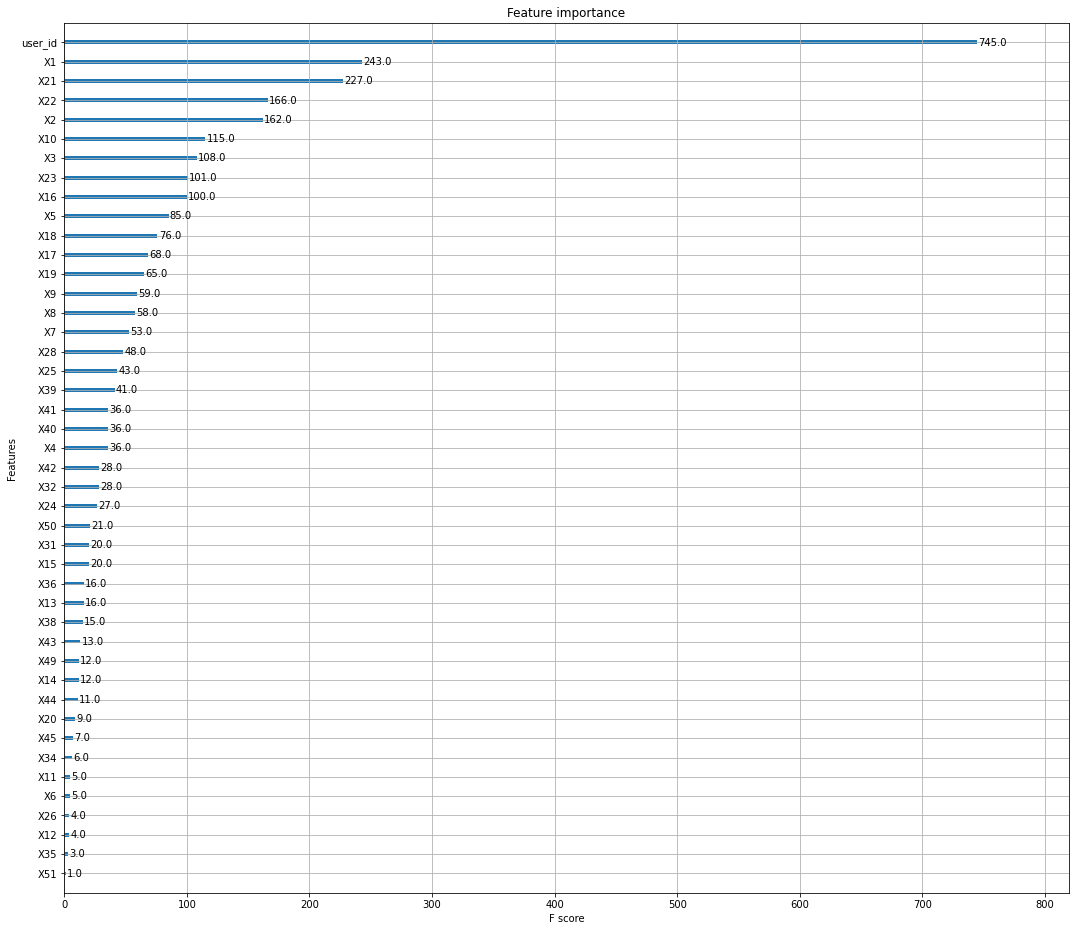

In [9]:
classifier = XGBClassifier(eval_metric='logloss',use_label_encoder=False)
classifier.fit(X, y)

# predictions = 
fig, ax = plt.subplots(figsize=(18,16))
plot_importance(classifier, ax=ax)
plt.show();



In [27]:
# X_train['X10'].nunique()

47380

In [28]:
X = X.drop(['user_id'], axis=1)

In [1]:
XGBdata = xgb.DMatrix(data=X,label=y)
cross_val_results = cv(dtrain=XGBdata, params=params, 
                       nfold=5, metrics="auc", 
                       num_boost_round=200,early_stopping_rounds=20,
                       as_pandas=True)

print((cross_val_results["test-auc-mean"]).tail(1))

NameError: name 'xgb' is not defined

## 3. Initial EDA

In [15]:
test.isna().sum()

user_id    0
X1         0
X2         0
X3         0
X4         0
X5         0
X6         0
X7         0
X8         0
X9         0
X10        0
X11        0
X12        0
X13        0
X14        0
X15        0
X16        0
X17        0
X18        0
X19        0
X20        0
X21        0
X22        0
X23        0
X24        0
X25        0
X26        0
X27        0
X28        0
X29        0
X30        0
X31        0
X32        0
X33        0
X34        0
X35        0
X36        0
X37        0
X38        0
X39        0
X40        0
X41        0
X42        0
X43        0
X44        0
X45        0
X46        0
X47        0
X48        0
X49        0
X50        0
X51        0
dtype: int64

In [16]:
# let's check for any null values
train.isna().sum()

label      0
user_id    0
X1         0
X2         0
X3         0
X4         0
X5         0
X6         0
X7         0
X8         0
X9         0
X10        0
X11        0
X12        0
X13        6
X14        0
X15        0
X16        0
X17        0
X18        0
X19        0
X20        0
X21        0
X22        0
X23        0
X24        0
X25        0
X26        0
X27        0
X28        0
X29        0
X30        0
X31        0
X32        0
X33        0
X34        0
X35        0
X36        0
X37        0
X38        0
X39        0
X40        0
X41        0
X42        0
X43        0
X44        0
X45        0
X46        0
X47        0
X48        0
X49        0
X50        0
X51        0
dtype: int64

Only column number thirteen have 6 null values

In [17]:
# Checking if there is any constant columns

features = [feature for feature in train if feature.startswith('X')]
# print(features)
for feat in features:
    if (train[feat].nunique() == 1):
        print(feat)

X27
X29
X30
X33
X46
X47
X48


In [18]:
train['X13'].sample(30)

389918    0.0
318181    0.0
4916      0.0
189193    0.0
49922     0.0
394074    0.0
455669    1.0
3897      0.0
386773    0.0
161033    0.0
95170     0.0
443133    0.0
22494     0.0
249851    0.0
155821    0.0
127857    0.0
36921     0.0
284826    0.0
274233    0.0
79361     0.0
362645    0.0
20312     0.0
154578    0.0
366549    0.0
300501    1.0
76910     0.0
14007     0.0
456936    0.0
6569      0.0
248895    0.0
Name: X13, dtype: float64

In [19]:
# here we will remove all constant columns

constant_columns = list()
for feat in features:
    if (train[feat].nunique() == 1):
        constant_columns.append(feat)
train.drop(columns = constant_columns, inplace = True)
train.shape

(458798, 46)

## 3.1. Dealing with Missing Values

In [20]:
# as we know that feature x13 has few null values, let's count it
print(f" count of null values in X13 : {train.X13.isna().sum()}")

# let's print those null values rows
train[train['X13'].isna()]

 count of null values in X13 : 6


,label,user_id,X1,X2,X3,X4,X5,X6,X7,X8,...,X39,X40,X41,X42,X43,X44,X45,X49,X50,X51
21466,0,22566,5668,95,51,2,8,1,10,22,...,0,0,0,1,0,0,0,1,1,0
84178,0,88460,2208,14,37,1,2,3,1,21,...,0,0,0,0,0,0,0,0,0,0
106900,0,112376,19774,211,13,3,17,3,5,9,...,1,0,0,5,1,0,0,1,1,0
265342,0,279080,17963,113,94,3,11,2,10,27,...,0,0,0,1,0,0,0,1,1,0
278065,0,292519,6545,213,71,3,11,4,2,15,...,0,0,0,1,0,0,0,1,0,0
361654,0,380630,1,212,13,3,16,4,11,14,...,0,0,0,0,0,0,0,0,1,0


In [21]:
# we will use median imputation to deal with missing values in X13
train['X13'].fillna(value = round(train['X13'].mean()), inplace = True)
train.X13.isna().sum()

0

In [22]:
# let's remove constant columns from test sets too
test.drop(columns = constant_columns, inplace=True)
train.shape, test.shape

((458798, 46), (24148, 45))

In [23]:
# we don't need user_id column so we will remove it
train = train.drop(columns = ['user_id'])
test = test.drop(columns = ['user_id'])
train.head()

,label,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X39,X40,X41,X42,X43,X44,X45,X49,X50,X51
0,0,20972,14,13,3,11,1,2,15,26,...,0,0,0,0,0,0,0,0,1,0
1,0,7362,213,71,3,11,1,2,15,26,...,0,0,0,0,0,0,0,0,0,0
2,0,21216,215,71,3,11,1,2,15,14,...,0,0,0,0,0,0,0,0,0,0
3,0,2261,212,71,2,8,1,2,15,14,...,0,0,0,0,0,0,0,1,0,0
4,0,4543,213,71,2,8,1,2,15,14,...,0,0,0,0,0,0,0,0,0,0


In [24]:
test.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X39,X40,X41,X42,X43,X44,X45,X49,X50,X51
0,19364,213,51,2,8,1,2,15,26,48955,...,0,0,0,0,0,0,0,0,0,0
1,16000,212,13,3,11,1,2,15,26,48955,...,0,0,0,0,0,0,0,0,0,0
2,14482,78,51,2,8,1,2,15,26,49002,...,0,0,0,0,0,0,0,1,0,0
3,18074,175,51,2,8,1,2,15,26,48955,...,0,0,0,0,1,0,0,1,0,0
4,4807,213,71,3,11,1,2,15,18,48955,...,0,0,0,0,0,0,0,1,0,0


In [44]:
train.shape

(458798, 45)

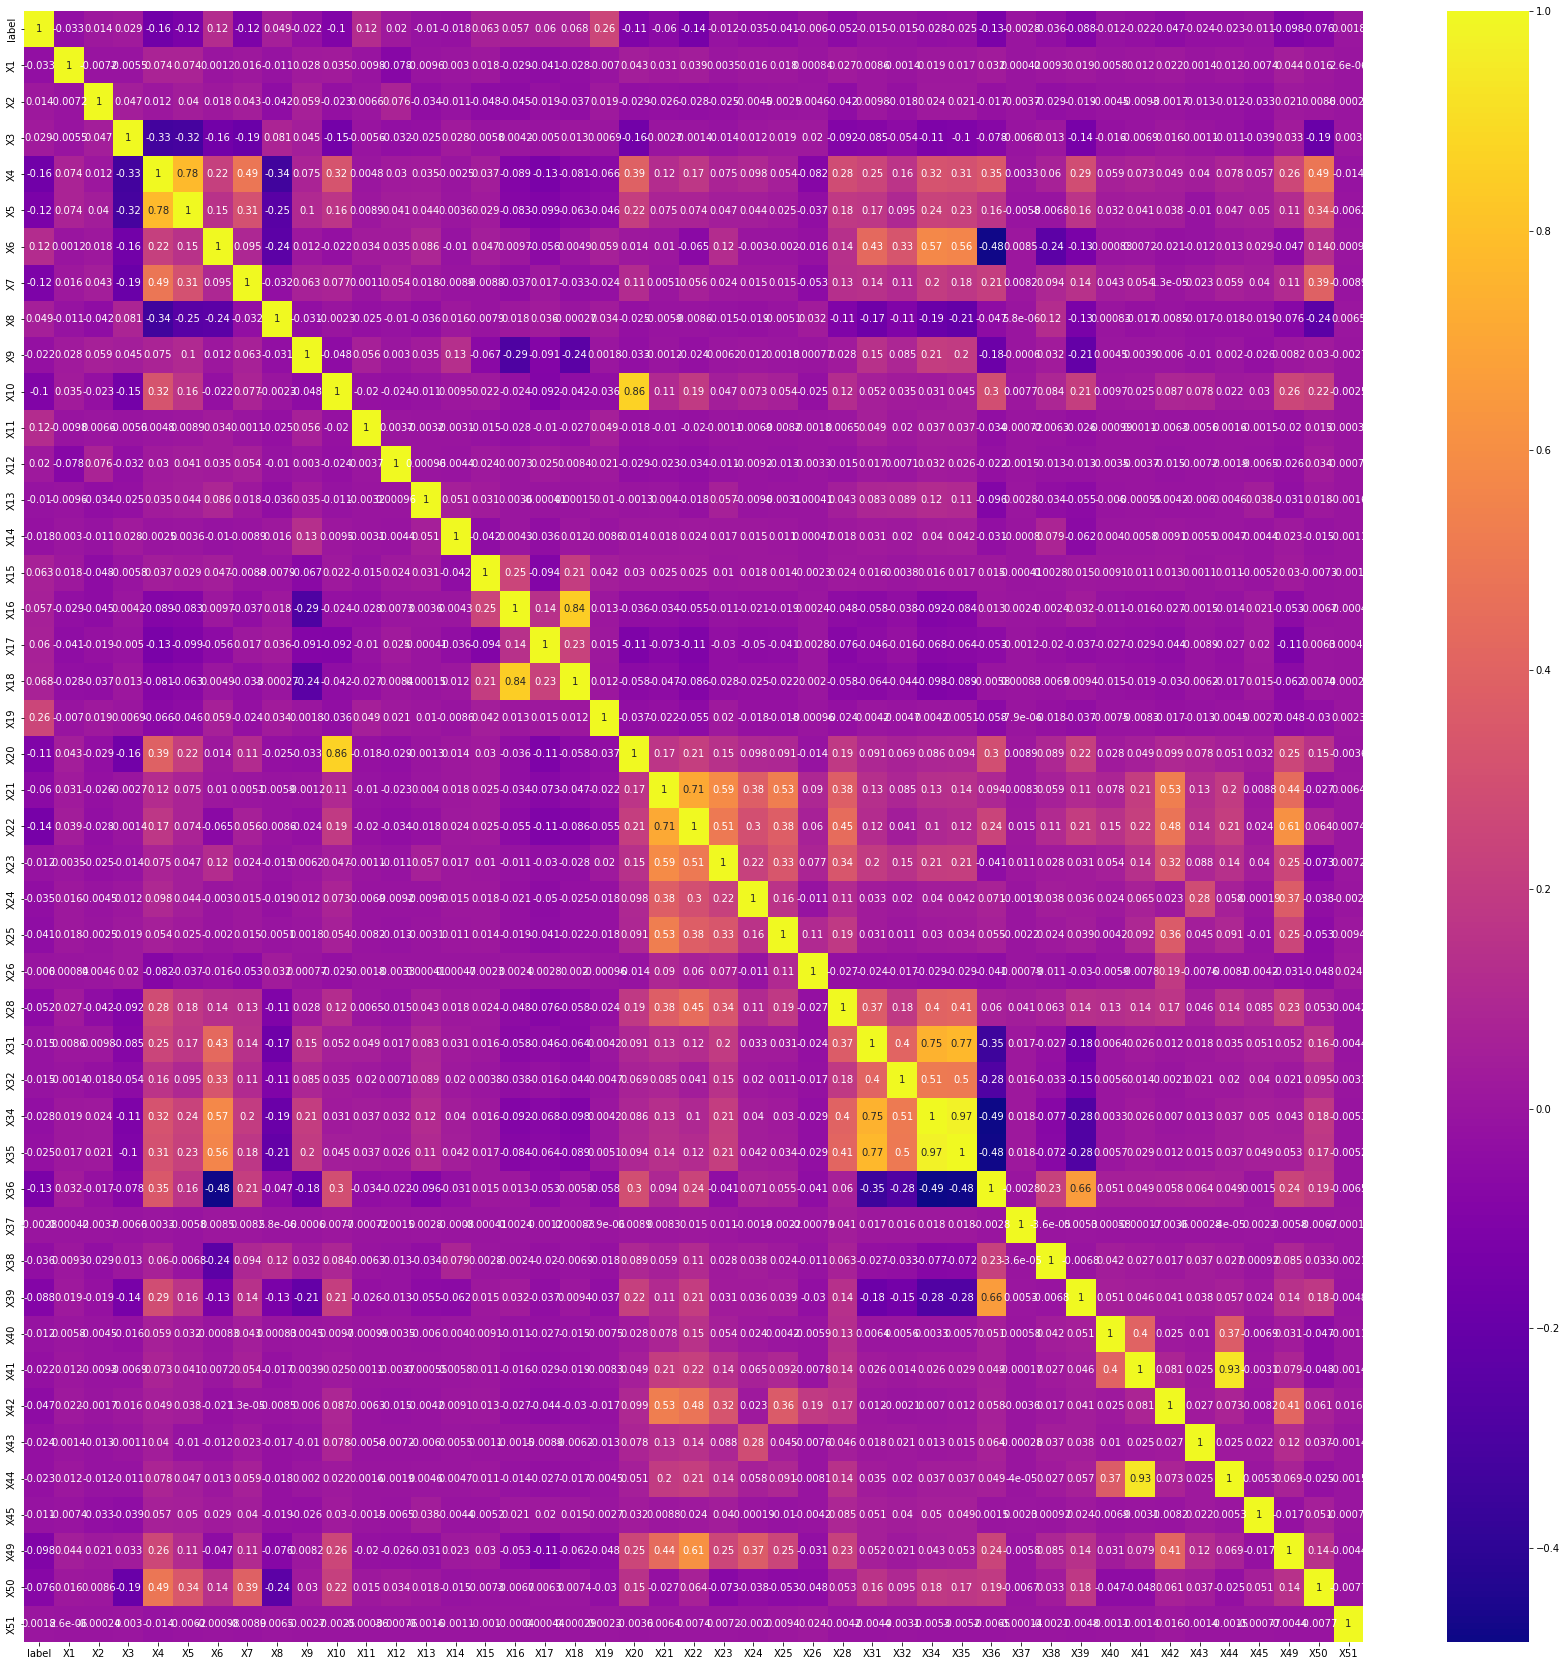

In [46]:
import seaborn as sns

# correlation matrix
cor = train.corr()
# correlation matrix heatmap
plt.figure(figsize=(30,30))
sns.heatmap(cor, annot = True, cmap="plasma")
plt.show()

In [47]:
# lets extract upper part only to see correlated features
upper_correlation = cor.where(np.triu(np.ones(cor.shape),k=1).astype(bool))
highly_correlated_features = [col for col in upper_correlation.columns if any(upper_correlation[col] > 0.8)]
print(highly_correlated_features)

['X18', 'X20', 'X35', 'X44']


In [48]:
# drop highly correlated features
train = train.drop(highly_correlated_features, axis=1)
train.shape

(458798, 41)

In [51]:
# Drop highly correlated features and user_id from test data
test_features_to_drop_sublist = [highly_correlated_features]
test_features_to_drop = [item for sublist in test_features_to_drop_sublist for item in sublist]
test = test.drop(test_features_to_drop,axis=1)
print(test.shape)

(24148, 40)


In [52]:
# assigning independent variables to X and dependent variable to y
X = train.drop(columns = ['label'])
y = train[['label']]

Let's split the data in training and validation set to use it in identification of XGBClassifier useful parameter values automatically

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((367038, 40), (91760, 40), (367038, 1), (91760, 1))

## 4. Building Model

In [54]:
# initializing xgbclassifier model
model_xgb = xgb.XGBClassifier(n_estimators = 700)


### 4.1. Fitting Model

In [68]:
# implementing XGBClassifier

model_xgb.fit(X_train, y_train, 
            early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
print(model_xgb)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [69]:
# initializing xgbclassifier model
model_xgb_tuned = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.277, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=800,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.28, reg_lambda=1)


# model_xgb_tuned = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
#               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#               early_stopping_rounds=None, enable_categorical=False,
#               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
#               importance_type=None, interaction_constraints='',
#               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
#               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
#               monotone_constraints='()', n_estimators=700,
#               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
#               reg_alpha=0, reg_lambda=1)


In [70]:
model_xgb_tuned.fit(X, y,
             verbose=False)
print(model_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=700,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [71]:
# to find out the accuracy, precision, recall and f1-score I will use the training data because we don't have true labels for test set on model_xgb
predictions_train = model_xgb_tuned.predict(X)
print(metrics.classification_report(y, predictions_train))
print(metrics.confusion_matrix(y, predictions_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    446477
           1       0.96      0.85      0.90     12321

    accuracy                           1.00    458798
   macro avg       0.98      0.92      0.95    458798
weighted avg       0.99      1.00      0.99    458798

[[446032    445]
 [  1839  10482]]


### Hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random forest
# n_jobs=-1 to allow run it on all cores

params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs1 = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs1.fit(X_train, y_train)

print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

In [ ]:
# XGBoost
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01,0.05,0.1],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 5],
    'base_score': [0.2, 0.5, 1]
}

gs2 = GridSearchCV(XGBClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs2.fit(X_train, y_train)

print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Extra Tree
# n_jobs=-1 to allow run it on all cores
params = {
    'n_estimators': [100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [1,2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [4,10,20,50,None]
}

gs3 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='roc_auc')
gs3.fit(X_train, y_train)

print('Best score:', gs3.best_score_)
print('Best score:', gs3.best_params_)


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

# votes = [
#     ('rf', RandomForestClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)),
#     ('xgb', XGBClassifier(n_jobs=-1, base_score=0.2, booster='gbtree', gamma=0, learning_rate=0.1, n_estimators=500, reg_alpha=0, reg_lambda=1)),
#     ('xt', ExtraTreesClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500))
# ]

votes = [
    ('rf', gs1.best_estimator_),
    ('xgb', gs2.best_estimator_),
    ('xt', gs3.best_estimator_)
]

# soft voting based on weights
votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
votesClass_cv = cross_validate(votesClass, X_train, y_train, cv=KFold(3, random_state=123))
votesClass.fit(X_train, y_train)

votesClass_cv

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [72]:
# now, reading the submission file to store the predictions in it
submission = pd.read_csv('/kaggle/input/predict-potential-spammers-on-fiverr/sample_submission.csv')
submission.head()

,user_id,label
0,57,0
1,58,0
2,59,0
3,60,0
4,61,0


In [73]:
predictions = model_xgb_tuned.predict(test)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [74]:
test.shape

(24148, 40)

In [75]:
submission.label = predictions
submission.columns = ['user_id', 'prediction']
submission.prediction.value_counts()

0    23176
1      972
Name: prediction, dtype: int64

In [76]:
submission.to_csv('submission2.csv', index = False)